In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 16 19:23:12 2020

@author: SOURAV
""" 
import PIL
from PIL import ImageTk, Image
from tkinter import *
import tkinter 
import cv2 
import os
import time 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm


protoFile = "model\\pose_deploy.prototxt"
weightsFile = "model\\pose_iter_102000.caffemodel"

nPoints = 21
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile) 
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

folderpath = "images"
root = tkinter.Tk()
root.geometry("500x500")
totalImages=5
quitflag = False
        
def getMarkedImage(frame):
    
    scale_percent = 50 
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100) 
    dsize = (width, height) 
    frame = cv2.resize(frame, dsize)
    
    inHeight,inWidth,_ = frame.shape 

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)
  
    net.setInput(inpBlob)
    
    output = net.forward()
    points = []
    frameHeight,frameWidth,_=frame.shape
    frameCopy=frame.copy()
    threshold=.05
    for i in range(nPoints):
    # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))
    
        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
        if prob > threshold :
            cv2.circle(frameCopy, (int(point[0]), int(point[1])), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 0, 255), 1, lineType=cv2.LINE_AA)
    
            # Add the point to the list if the probability is greater than the threshold
            points.append((int(point[0]), int(point[1])))
        else :
            points.append(None)
    return frameCopy,points


def captureImage():
    i=1
    vid = cv2.VideoCapture(0)
    while i<=totalImages:
        ret, frame = vid.read() 
        
        f,p = getMarkedImage(frame.copy())
        
#         Display Pic
        frameCopy = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = ImageTk.PhotoImage(image = PIL.Image.fromarray(frameCopy))  
        canvas.create_image(130,100, image=img) 
    
        
        folderName = os.path.join(folderpath,E1.get())
        if not os.path.exists(folderName):
            os.mkdir(folderName)
        filename = os.path.join(folderName,str(i)+".jpg")
        if p.count(None)==0:
            cv2.imwrite(filename, frame)  
            var.set(str(i)+".jpg saved")
            i+=1
        else:
            var.set("None "+str(p.count(None)))
        root.update()
        time.sleep(1)
    vid.release() 

f = Frame()

E1 = Entry(f)
E1.delete(0,END)
E1.insert(0,"1") 
E1.pack(side = LEFT)

B = tkinter.Button(f, text ="Capture", command = captureImage)
B.pack(side=LEFT)

var = StringVar()
var.set('Ready')
L1 = Label(f,textvariable = var)
L1.pack(side=LEFT)
canvas = Canvas(root, width = 400, height = 300, bg="black")      
canvas.pack(side=TOP) 



def checkImage():
    image_count=1
    while image_count<=totalImages:   
        folderName = os.path.join(folderpath,E1.get())
        if not os.path.exists(folderName):
            return
        filename = os.path.join(folderName,str(image_count)+".jpg")  
        # img = PIL.Image.open(filename)
        # w,h = img.size 
        # img = ImageTk.PhotoImage(img.resize((w//2,h//2)) )  
        
        #Detect points 
        if not os.path.exists(filename):
            print(filename,"Does not exist")
            return None,None
        frame = cv2.imread(filename)
    
        frame,p = getMarkedImage(frame) 
        frameCopy = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = ImageTk.PhotoImage(image = PIL.Image.fromarray(frameCopy))  
        canvas.create_image(100,100, image=img) 
    
        
#         Display Pic
        frameCopy = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = ImageTk.PhotoImage(image = PIL.Image.fromarray(frameCopy))  
        canvas.create_image(100,100, image=img) 
    
        var.set(str(image_count)+".jpg Displayed") 
        image_count+=1
        root.update() 

#Feature extraction
def extractFeatures():
    signs=['left','right','middle']
    features=None
    output=[]
    for s in signs:
        folderName = os.path.join(folderpath,s)
        for pic in os.listdir(folderName):
            print(folderName,pic)
            f,p = getMarkedImage(cv2.imread(os.path.join(folderName,pic)))
            if features is None:
                features =  np.expand_dims(np.array(p),axis=0)
            else:
                features =  np.concatenate((features,np.expand_dims(np.array(p),axis=0)),axis=0)
            output.append(s)
    np.save("data_features.npy",features)
    np.save("data_output.npy",output)
    
    
def predict():
    f= np.load("data_features.npy")
    o= np.load("data_output.npy") 
    f = f.reshape((len(o),-1))  
    
    clf = svm.SVC()
    clf.fit(f, o)
    vid = cv2.VideoCapture(0)
    i=0
    while i<=10:  
        ret, frame = vid.read()  
        f,p = getMarkedImage(frame.copy()) 
        frameCopy = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
        img = ImageTk.PhotoImage(image = PIL.Image.fromarray(frameCopy))  
        canvas.create_image(130,100, image=img) 
     
        if p.count(None)==0: 
            features = np.array(p)
            features = features.reshape((1,-1))
            var.set( "Prediction = "+clf.predict(features)[0]) 
            i+=1
        else:
            var.set("None "+str(p.count(None)))
            
        root.update() 
    vid.release() 
    
bottomFrame = Frame(root)

B = tkinter.Button(bottomFrame, text ="Check", command = checkImage)
B.pack(side=LEFT)

C = tkinter.Button(bottomFrame, text ="Train", command = extractFeatures)
C.pack(side=LEFT)

D = tkinter.Button(bottomFrame, text ="Predict", command = predict)
D.pack(side=LEFT)

bottomFrame.pack(side=BOTTOM)
f.pack(side=BOTTOM)


root.mainloop()

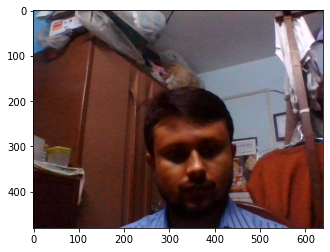

In [40]:
vid = cv2.VideoCapture(0)
ret, frame = vid.read() 
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
vid.release() 